# Setup

This Colab uses the wine quality dataset<sup>[1]</sup>, which is hosted at [UCI](https://archive.ics.uci.edu/ml/datasets/wine+quality). This dataset contains data on the physicochemical properties of wine along with wine quality ratings. The problem is to predict wine quality (0-10) from physicochemical properties.

In [1]:
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format

In [5]:
wineDf = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/winequality.csv',
                     encoding='latin-1')
wineDf.columns = ['fixed acidity','volatile acidity','citric acid',
                  'residual sugar','chlorides','free sulfur dioxide',
                  'total sulfur dioxide','density','pH',
                  'sulphates','alcohol','quality']

wineDf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.00,0.27,0.36,20.70,0.04,45.00,170.00,1.00,3.00,0.45,8.80,6
1,6.30,0.30,0.34,1.60,0.05,14.00,132.00,0.99,3.30,0.49,9.50,6
2,8.10,0.28,0.40,6.90,0.05,30.00,97.00,1.00,3.26,0.44,10.10,6
3,7.20,0.23,0.32,8.50,0.06,47.00,186.00,1.00,3.19,0.40,9.90,6
4,7.20,0.23,0.32,8.50,0.06,47.00,186.00,1.00,3.19,0.40,9.90,6


# Check Correlation Matrix

Before developing your ML model, you need to select features. To find informative features, check the correlation matrix by running the following cell. Which features are informative?

<AxesSubplot:>

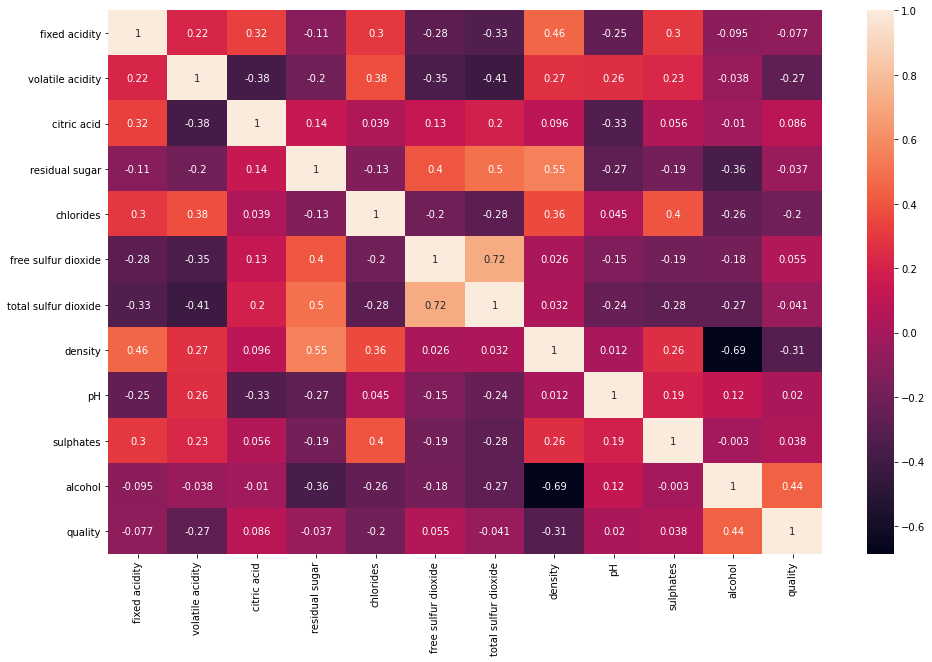

In [6]:
corr_wineDf = wineDf.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_wineDf, annot=True)

`alcohol` is most highly correlated with `quality`. Looking for other informative features, notice that `volatile acidity` correlates with `quality` but not with `alcohol`, making it a good second feature. Remember that a correlation matrix is not helpful if predictive signals are encoded in combinations of features.

# Validate Input Data against Data Schema

Before processing your data, you should validate the data against a data schema as described in [Data and Feature Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors).

First, define a function that validates data against a schema.

In [24]:
# Define function to validate data
def test_data_schema(input_data, schema):
    """Tests that the datatypes and ranges of values in the dataset
        adhere to expectations.

        Args:
          input_function: Dataframe containing data to test
          schema: Schema which describes the properties of the data.
    """
    def test_dtypes():
        for column in schema.keys():
            assert input_data[column].map(type).eq(schema[column]['dtype']).all(),(
                'Incorrect dtype in column "%s",' %column)
        print('Input dtypes are correct')
        
    def test_ranges():
        for column in schema.keys():
            schema_max = schema[column]['range']['max']
            schema_min = schema[column]['range']['min']
            # Assert that data falls between schema min and max.
            assert input_data[column].max() <= schema_max, (
            "Maximum value of column '%s' is too low." %column)
            assert input_data[column].min() >= schema_min, (
            "Minimum value of column '%s' is too high." %column)
        print('Data falls within specified ranges')
    
    test_dtypes()
    test_ranges()

In [19]:
wineDf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00
mean,7.22,0.34,0.32,5.44,0.06,30.53,115.74,0.99,3.22,0.53,10.49,5.82
std,1.30,0.16,0.15,4.76,0.04,17.75,56.52,0.00,0.16,0.15,1.19,0.87
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00
25%,6.40,0.23,0.25,1.80,0.04,17.00,77.00,0.99,3.11,0.43,9.50,5.00
50%,7.00,0.29,0.31,3.00,0.05,29.00,118.00,0.99,3.21,0.51,10.30,6.00
75%,7.70,0.40,0.39,8.10,0.07,41.00,156.00,1.00,3.32,0.60,11.30,6.00
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,9.00


Using the statistics generated above, define the data schema in the following code cell. For demonstration purposes, restrict your data schema to the first three data columns. For each data column, enter the:

 * minimum value
 * maximum value
 * data type

As an example, the values for the first column are filled out. After entering the values, run the code cell to confirm that your input data matches the schema.

In [25]:
wine_schema = {
    'fixed acidity': {
        'range': {
            'min': 3.8,
            'max': 15.9
        },
        'dtype': float,
    },
    'volatile acidity': {
        'range': {
            'min': 0.08,
            'max': 1.58
        },
        'dtype': float,
    },
    'citric acid': {
        'range':{
            'min': 0.,
            'max': 1.66
        },
        'dtype': float
    }
}

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

Validating wine data against data schema...
Input dtypes are correct
Data falls within specified ranges


In [20]:
wineDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


# Split and Normalize Data

Split the dataset into data and labels.